# **nobrianer**: brian exercises with a focus on dendrites

### Exercise 1

a. Create a adaptive integrate-and-fire (I&F) point neuron model with the following properties:
\begin{gather*}
\tau ≃ 50ms\\
R_{input} ≃ 150 M\Omega\\
V_{rest} ≃ -70 mV\\
V_{threshold} ≃ -50 mV\\
\end{gather*}
b. Figure out the leak capacitance $g_L$ and conductance $C$ values

c. Plot the F-I curve

In [1]:
!pip install matplotlib==3.6.1 --quiet
!pip install brian2==2.5.0.3 --quiet

In [2]:
import brian2 as b
from brian2.units import second, Hz, ms, um, cm, ohm, Mohm, mV, pF, uF, uS, nS, psiemens as pS, mV, pA
b.prefs.codegen.target = 'numpy'
from IPython.core.debugger import set_trace

tau_experimental: 50. ms
tau: 50. ms
Rinput_experimental: 150. Mohm
Rinput: 150.48438883 Mohm


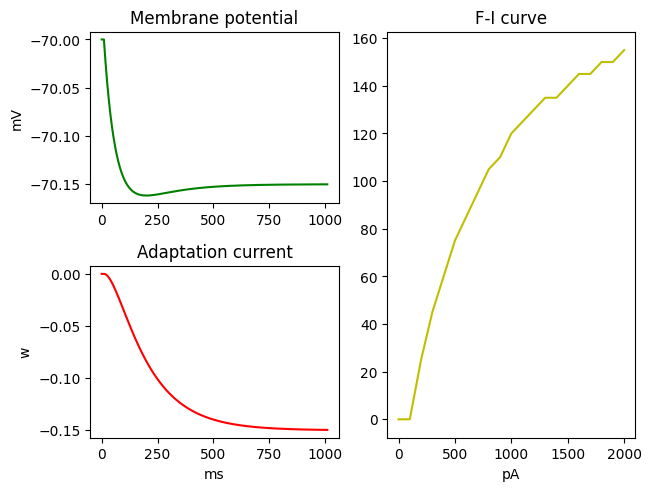

In [3]:
### Define point neuron
# Experimental data
tau_experimental = 50*ms
Rinput_experimental = 150*Mohm
# Simulation data
duration = 1000*ms
# Model parameters
EL = -70*mV
Vth = -50*mV
Vr = -60*mV
sf = 0.565
C = 500*pF*sf
gL = 10*nS*sf
tau = C/gL
print(f'tau_experimental: {tau_experimental}')
print(f'tau: {tau}')
Ie = -1*pA
a = 1*nS
tau_wadapt = 200*ms
beta = 10*pA
# Adex term: gL*DeltaT*exp((V-Vth)/DeltaT)
# DeltaT = 2*mV
point_neuron_model = '''
dV/dt = (gL*(EL-V)-wadapt+I)/C  : volt (unless refractory)
dwadapt/dt = (a*(V-EL)-wadapt)/tau_wadapt  :amp
I : amp
'''
### Define neuron
neurongroup = b.NeuronGroup(N=1, model=point_neuron_model, refractory=5*ms, threshold='V > Vth',
                      reset='V = Vr; wadapt += beta', method='exponential_euler')
neurongroup.V = EL
### Define monitors
M = b.StateMonitor(neurongroup, variables=['V', 'wadapt'], record=True)
SM = b.SpikeMonitor(neurongroup)
n = b.Network(neurongroup, M, SM)
n.store()
n.run(10*ms)
### Inject current and calculate voltage & adaptation current
neurongroup.I = Ie
n.run(duration)
time = M.t/ms
v = M.V[0]/mV
dV = abs(v[-1]*mV-EL)
Rinput = dV/abs(Ie)
print(f'Rinput_experimental: {Rinput_experimental}')
print(f'Rinput: {Rinput}')
adaptation_current = M.wadapt[0]/pA
### Inject currents and calculate F-I curve
cur_duration = 200*ms
currents = []
rates = []
for current in range(0, 2000 + 100, 100):
    n.restore()
    cur = current*pA
    neurongroup.I = cur
    n.run(cur_duration)
    currents.append(cur/pA)
    rates.append(SM.num_spikes/cur_duration)
### Plot
fig = b.plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[:,-1])
ax1.set_title("Membrane potential")
ax1.plot(time, v, c='g')
ax1.set_ylabel(mV)
ax2.set_title("Adaptation current")
ax2.plot(time, adaptation_current, c='r')
ax2.set_ylabel("w")
ax2.set_xlabel(ms)
ax3.plot(currents, rates, c='y')
ax3.set_xlabel("Hz")
ax3.set_xlabel("pA")
ax3.set_title("F-I curve")
b.show()

### Exercise 2

The following equations describe four compartments of a neuron: soma, trunk, basal and distal dendrite. The distal dendrite receives AMPA and NMDA synapses from region 1, whereas the basal one from region 2.

i. Implement an I&F point neuron model with AMPA and NMDA currents

ii. Run a $500ms$ simulation during which you activate (once) a region 1 synapse (@ $100ms$) and a region 2 synapse (@ $250ms$). For convenience, set $g_{AMPA} = g_{NMDA}$. Then, find the conductance values that yield $1mV$ and $2mV$ for the region 1 and region 2 synapses, respectively. Make sure to maintain the experimental $\tau$ and $R_{input}$ from **example 1**.

In [4]:
multicpt_model = '''
dV_soma/dt = (gL_soma*(EL_soma-V_soma) + I_soma)/C_soma  : volt
I_soma = Iext_soma + I_apical_soma + I_basal_soma : amp
Iext_soma : amp
I_apical_soma = g_soma_apical*(V_apical-V_soma) : amp
I_basal_soma = g_soma_basal*(V_basal-V_soma) : amp

dV_apical/dt = (gL_apical*(EL_apical-V_apical) + I_apical)/C_apical : volt
I_apical = Iext_apical + I_soma_apical + I_distal_apical : amp
Iext_apical : amp
I_soma_apical = g_soma_apical*(V_soma-V_apical) : amp
I_distal_apical = g_apical_distal*(V_distal-V_apical) : amp

dV_basal/dt = (gL_basal*(EL_basal-V_basal) + I_basal)/C_basal : volt
I_basal = Iext_basal + I_soma_basal + I_NMDA_basal + I_AMPA_basal + I_noise_basal : amp
Iext_basal : amp
I_soma_basal = g_soma_basal*(V_soma-V_basal) : amp
I_NMDA_basal = g_NMDA_basal*(E_NMDA-V_basal)*s_NMDA_basal/(1.0 + eta*Mg*exp(-gamma*V_basal)) : amp
I_AMPA_basal = g_AMPA_basal*(E_AMPA-V_basal)*s_AMPA_basal : amp
dI_noise_basal/dt = (mean_noise_basal-I_noise_basal) / tau_noise_basal + sigma_noise_basal * (sqrt(2/tau_noise_basal) * xi_basal) :amp

ds_NMDA_basal/dt = -s_NMDA_basal/tau_NMDA : 1
ds_AMPA_basal/dt = -s_AMPA_basal/tau_AMPA : 1

dV_distal/dt = (gL_distal*(EL_distal-V_distal) + I_distal)/C_distal : volt
I_distal = Iext_distal + I_apical_distal + I_NMDA_distal + I_AMPA_distal + I_noise_distal : amp
Iext_distal : amp
I_apical_distal = g_apical_distal*(V_apical-V_distal) : amp
I_NMDA_distal = g_NMDA_distal*s_NMDA_distal*(E_NMDA-V_distal)/(1.0 + eta*Mg*exp(-gamma*V_distal)) : amp
I_AMPA_distal = g_AMPA_distal*s_AMPA_distal*(E_AMPA-V_distal) : amp
dI_noise_distal/dt = (mean_noise_distal-I_noise_distal) / tau_noise_distal + sigma_noise_distal * (sqrt(2/tau_noise_distal) * xi_distal) :amp

ds_NMDA_distal/dt = -s_NMDA_distal/tau_NMDA : 1
ds_AMPA_distal/dt = -s_AMPA_distal/tau_AMPA : 1
'''
# print(multicpt_model)

In [5]:
point_neuron_w_synapses_model = '''
dV/dt = (gL*(EL-V) + I)/C  : volt (unless refractory)
I = Iext + I_NMDA_region1 + I_AMPA_region1 + I_NMDA_region2 + I_AMPA_region2 : amp
Iext : amp
I_NMDA_region1 = g_NMDA_region1*(E_NMDA-V)*s_NMDA_region1/(1.0 + eta*Mg*exp(-gamma*V)) : amp
I_AMPA_region1 = g_AMPA_region1*(E_AMPA-V)*s_AMPA_region1 : amp
I_NMDA_region2 = g_NMDA_region2*s_NMDA_region2*(E_NMDA-V)/(1.0 + eta*Mg*exp(-gamma*V)) : amp
I_AMPA_region2 = g_AMPA_region2*s_AMPA_region2*(E_AMPA-V) : amp
ds_NMDA_region1/dt = -s_NMDA_region1/tau_NMDA : 1
ds_AMPA_region1/dt = -s_AMPA_region1/tau_AMPA : 1
ds_NMDA_region2/dt = -s_NMDA_region2/tau_NMDA : 1
ds_AMPA_region2/dt = -s_AMPA_region2/tau_AMPA : 1
'''
# print(point_neuron_w_synapses_model)

tau_experimental: 50. ms
tau: 50. ms
incoming spike @ region_1 @ [100. * msecond] -> dV: 1.0569583 mV
incoming spike @ region_2 @ [250. * msecond] -> dV: 2.05516768 mV
Rinput_experimental: 150. Mohm
Rinput (of V): 150.5663736 Mohm


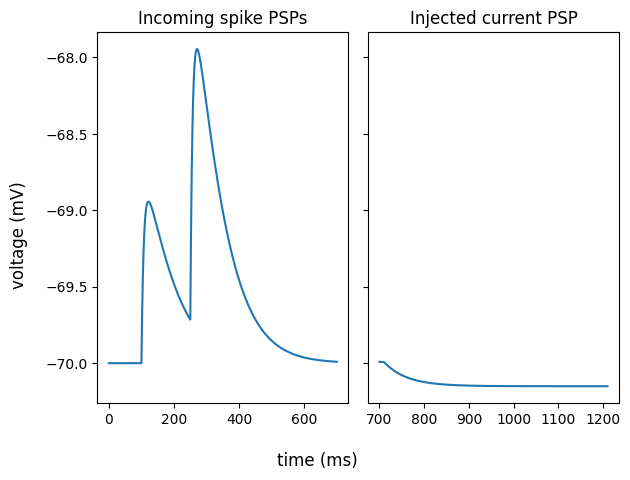

In [6]:
### Model parameters
sf = 0.6641
C = 500*pF*sf
gL = 10*nS*sf
tau = C/gL
print(f'tau_experimental: {tau_experimental}')
print(f'tau: {tau}')
E_AMPA = 0*mV
E_NMDA = 0*mV
tau_AMPA = 7*ms
tau_NMDA = 70*ms
g_AMPA_region1 = 0.75*nS
g_AMPA_region2 = 1.3*nS
g_AMPA_region1 = g_NMDA_region1 = g_AMPA_region1
g_AMPA_region2 = g_NMDA_region2 = g_AMPA_region2
gamma = 0.062*mV**-1
Mg = 1           
eta = 0.1
def create_spike_generators(n=2, num_neurons=1, indices=[0], spike_times=[[100*ms], [250*ms]]):
    assert len(indices) <= n
    assert all(len(indices) == len(spkt) for spkt in spike_times) 
    return tuple((b.SpikeGeneratorGroup(num_neurons, indices, spike_times[idx]), spike_times[idx])
                 for idx in range(n))
def validate_target(neuron_group, monitor, voltage_monvars, network,
                    tspikes, tspikes_idx_to_region_map, injection_variables,
                    injection_current, legend_params={}):
    assert len(tspikes_idx_to_region_map) == len(tspikes)
    ### Simulate
    network.restore()
    duration = 700*ms
    network.run(duration)
    ### Handle and print incoming spike data
    t_firstrun = list(monitor.t)
    v_firstruns = []
    spikeidcs = [int(tspike/neuron_group.dt) for tspike in tspikes]
    for idx, (spikeidx, tspike) in enumerate(zip(spikeidcs, tspikes)):
        slc = slice(spikeidx, spikeidcs[idx+1]) if idx < len(tspikes) - 1 else slice(spikeidx, None)
        print(f'incoming spike @ {tspikes_idx_to_region_map[idx]} @ {tspike} -> ', end='', flush=True)
        dVstrings = []
        for vmn in voltage_monvars:
            v_firstrun = getattr(monitor, vmn)[0]
            v_firstruns.append(v_firstrun)
            # Assumes v_firstrun[0] == EL
            dVspike = max(abs(v_firstrun[0] - v_firstrun[slc]))
            dVstrings.append(f'd{vmn}: {dVspike}')
        print(f"{', '.join(dVstrings)}")
    ### Inject validation current
    network.run(10*ms)
    for injv in injection_variables:
        setattr(neuron_group, injv, injection_current)
    injduration = 500*ms
    network.run(injduration)
    for injv in injection_variables:
        setattr(neuron_group, injv, 0*pA)
    ### Plot incoming spike and injected current PSPs
    fig, (ax1, ax2) = b.plt.subplots(1, 2, sharey=True)
    ax1.set_title('Incoming spike PSPs')
    ax2.set_title('Injected current PSP')
    show_legend = False
    plot_kwargs = {}
    t = monitor.t/ms
    vs = []
    ax2_plot_start_idx = int(duration/neuron_group.dt)
    for idx, vmn in enumerate(voltage_monvars):
        if vmn.startswith('V_'):
            # Assumes voltage format V_{cpt}
            plot_kwargs['label'] = vmn.split('_')[1]
            show_legend = True
        ax1.plot(t_firstrun/ms, v_firstruns[idx]/mV, **plot_kwargs)
        v = getattr(monitor, vmn)[0]/mV
        vs.append(v)
        ax2.plot(t[ax2_plot_start_idx:], v[ax2_plot_start_idx:], **plot_kwargs)
    fig.supylabel('voltage (mV)')
    fig.supxlabel('time (ms)')
    if show_legend:
        handles, labels = ax2.get_legend_handles_labels()
        fig.legend(labels, **legend_params)
    fig.tight_layout()
    ### Print Rinput
    print(f'Rinput_experimental: {Rinput_experimental}')
    for v, vmn in zip(vs, voltage_monvars):
        # Assumes maximum dV at v[-1] and v[0] == EL
        dV = abs(v[-1]*mV-v[0]*mV)
        Rinput = dV/abs(injection_current)
        print(f'Rinput (of {vmn}): {Rinput}')
### Define point neuron
g = b.NeuronGroup(
    N=1,
    model=point_neuron_w_synapses_model,
    refractory=3*ms,
    threshold='V > Vth',
    reset='V = Vr',
    method='exponential_euler')
g.V = EL
### Create synapses
(ingroup1, tspikes1), (ingroup2, tspikes2) = create_spike_generators()
tspikes = (tspikes1, tspikes2)
tspikes_idx_to_region_map = ['region_1', 'region_2']  # e.g. tspikes[0] occur on region tspikes_idx_to_region_map[0]
synregion1 = b.Synapses(ingroup1, g, on_pre='s_AMPA_region1 += 1;s_NMDA_region1 += 1')
synregion2 = b.Synapses(ingroup2, g, on_pre='s_AMPA_region2 += 1;s_NMDA_region2 += 1')
synregion1.connect(j='0')
synregion2.connect(j='0')
### Create network
voltage_monvars = ('V')
monvars = voltage_monvars
mon = b.StateMonitor(g, monvars, record=True)
n = b.Network(g, ingroup1, ingroup2, synregion1, synregion2, mon)
n.store()
injection_variables = ('Iext',)
### Validate neuron
validate_target(neuron_group=g, monitor=mon,
                voltage_monvars=voltage_monvars,
                network=n, tspikes=tspikes,
                tspikes_idx_to_region_map=tspikes_idx_to_region_map,
                injection_variables=injection_variables,
                injection_current=Ie)

### Exercise 3

i. Based on the compartment equations given in **example 2**, implement an I&F **compartmental** neuron model. Modify the **somatic** $C$ and $gL$ to make sure $R{input}$ remains unchanged.

ii. Reproduce panel **b**. Include your extra compartment.

![](img/ab.png)

tau_experimental: 50. ms
tau_basal: 50. ms
tau_soma: 50. ms
tau_apical: 50. ms
tau_distal: 50. ms
Rinput_experimental: 150. Mohm
Rinput @ basal: 186.8535421 Mohm (dV: 37.37070842 mV)
Rinput @ soma: 148.4004203 Mohm (dV: 29.68008406 mV)
Rinput @ apical: 153.11293026 Mohm (dV: 30.62258605 mV)
Rinput @ distal: 188.70619497 Mohm (dV: 37.74123899 mV)


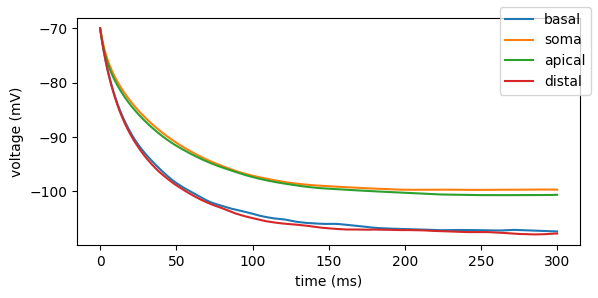

In [7]:
EL_soma = EL_apical = EL_basal = EL_distal = EL
g_soma_apical = g_soma_basal = g_apical_distal = 10*nS
g_AMPA_basal = g_NMDA_basal = g_AMPA_distal = g_NMDA_distal = 2*nS
C_basal = C_apical = C_distal = 100*pF
gL_basal = gL_apical = gL_distal = 2*nS
mean_noise_distal = mean_noise_basal = 0*pA
sigma_noise_distal = sigma_noise_basal = 2*pA
tau_noise_distal = tau_noise_basal = 20*ms
sf = 0.58
C_soma = 200*pF*sf
gL_soma = 4*nS*sf
CPTS = ('basal', 'soma', 'apical', 'distal')
print(f'tau_experimental: {tau_experimental}')
LVARS = locals()
print(*(f"tau_{cpt}: {LVARS[f'C_{cpt}']/LVARS[f'gL_{cpt}']}" for cpt in CPTS), sep='\n')
### Define compartmental neuron
g = b.NeuronGroup(
    N=1,
    model=multicpt_model,
    refractory=3*ms,
    threshold='V_soma > Vth',
    reset='V_soma = Vr',
    method='euler')
for cpt in CPTS:
    setattr(g, f'V_{cpt}', LVARS[f'EL_{cpt}'])
monvars = [f'V_{cpt}' for cpt in CPTS]
mon = b.StateMonitor(g, monvars, record=True)
n = b.Network(g, mon)
n.store()
n.run(10*ms)
### Inject current in every compartment
Iinj = -200*pA
injduration = 300*ms
voltages = {}
for cpt in CPTS:
    n.restore()
    setattr(g, f'Iext_{cpt}', Iinj)
    n.run(injduration)
    time = mon.t/ms
    voltages[cpt] = getattr(mon, f'V_{cpt}')[0]/mV
### Plot
fig, ax = b.subplots(figsize=[6, 3])
for cpt, v in voltages.items():
    ax.plot(time, v, label=cpt)
fig.legend()
ax.set_xlabel('time (ms)')
ax.set_ylabel('voltage (mV)')
fig.tight_layout()
### Print Rinputs
print(f'Rinput_experimental: {Rinput_experimental}')
for cpt in CPTS:
    dV = abs(voltages[cpt][-1]*mV-LVARS[f'EL_{cpt}'])
    Rinput = dV/abs(Iinj)
    print(f'Rinput @ {cpt}: {Rinput} (dV: {dV})')
n.restore()

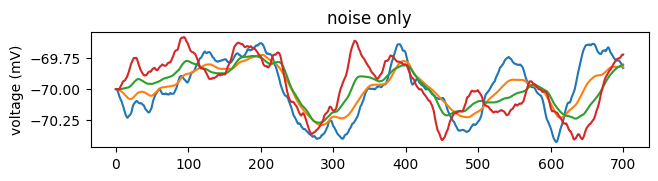

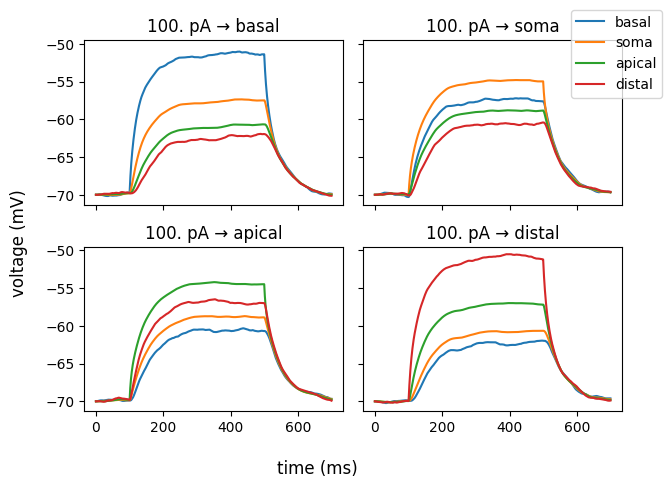

In [8]:
### Define neurons vector for ease of simulation
nplots = len(CPTS) + 1  # 1 plot per compartment plus 1 plot only for noise
g = b.NeuronGroup(
    N=nplots,
    model=multicpt_model,
    refractory=3*ms,
    threshold='V_soma > Vth',
    reset='V_soma = Vr',
    method='euler')
for cpt in CPTS:
    setattr(g, f'V_{cpt}', LVARS[f'EL_{cpt}'])
# Add poisson noise
# noise = b.PoissonGroup(nplots, 20*Hz)
# synbasal = b.Synapses(noise, g, on_pre='s_AMPA_basal += 0.1;s_NMDA_basal += 0.1')
# syndistal = b.Synapses(noise, g, on_pre='s_AMPA_distal += 0.1;s_NMDA_distal += 0.1')
# synbasal.connect(j='i')
# syndistal.connect(j='i')
monvars = [f'V_{cpt}' for cpt in CPTS]
mon = b.StateMonitor(g, monvars, record=True)
n = b.Network(g, mon)
def inject(current):
    for idx, cpt in enumerate(CPTS):
        setattr(g[idx+1], f'Iext_{cpt}', current)
n.run(100*ms)
Iinj_cpt = 100*pA
inject(Iinj_cpt)
n.run(400*ms)
inject(0*pA)
n.run(200*ms)
### Plot
noisefig, ax0 = b.plt.subplots(figsize=[7.2, 1.5])
ax0.set_title('noise only')
ax0.set_ylabel('voltage (mV)')
time = mon.t/ms
# Plot noise only
for cpt in CPTS:
    vcpt = getattr(mon, f'V_{cpt}')[0]/mV
    ax0.plot(time, vcpt, label=cpt)
fig, axes = b.plt.subplots(2, 2, sharex=True, sharey=True)
axes = axes.flatten()
# Set title
assert len(axes) == len(CPTS)
for ax, cpt in zip(axes, CPTS):
    ax.set_title(f'{Iinj_cpt} \u2192 {cpt}')
# Plot injection responses
assert len(axes) == len(CPTS)
for idx, ax in enumerate(axes):
    for cpt in CPTS:
        vcpt = getattr(mon, f'V_{cpt}')[idx+1]/mV
        ax.plot(time, vcpt, label=cpt)
fig.supylabel('voltage (mV)')
fig.supxlabel('time (ms)')
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(labels, loc='upper right', bbox_to_anchor=(1.05,1))
fig.tight_layout()

### Example 4

i. Using your compartmental neuron model from **example 3**, repeat **2ii**. Adjust the synaptic conductances $g$ so that both (basal and distal) synaptic currents result in an EPSP of $1mV$

ii. Reproduce panels **c**, **d**. Include an "*NMDA only*" scenario.

![](img/cd.png)

incoming spike @ distal @ [100. * msecond] -> dV_basal: 242.64165626 uV, dV_soma: 301.04441358 uV, dV_distal: 1.02166301 mV
incoming spike @ basal @ [250. * msecond] -> dV_basal: 1.03267485 mV, dV_soma: 0.53886053 mV, dV_distal: 307.93998463 uV
Rinput_experimental: 150. Mohm
Rinput (of V_basal): 125.31377478 Mohm
Rinput (of V_soma): 150.37818155 Mohm
Rinput (of V_distal): 91.69145517 Mohm


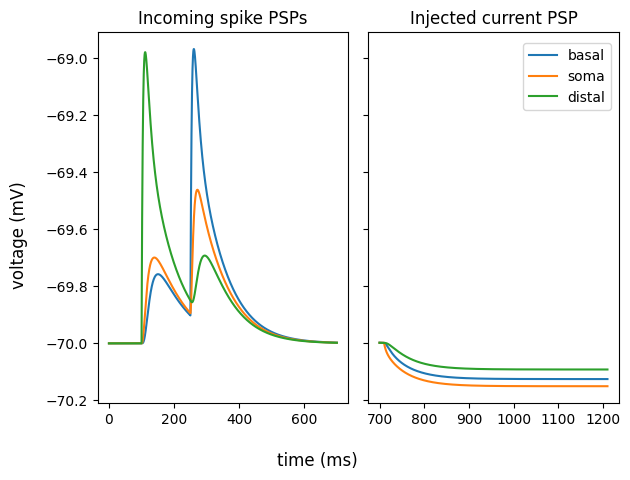

In [9]:
### Define neuron
g = b.NeuronGroup(
    N=1,
    model=multicpt_model,
    refractory=3*ms,
    threshold='V_soma > Vth',
    reset='V_soma = Vr',
    method='euler')
for cpt in CPTS:
    setattr(g, f'V_{cpt}', LVARS[f'EL_{cpt}'])
### Create synapses
(ingroup1, tspike1), (ingroup2, tspike2) = create_spike_generators()
tspikes = (tspike1, tspike2)
tspikes_idx_to_region_map = ['distal', 'basal']
synregion1 = b.Synapses(ingroup1, g, on_pre='s_AMPA_distal += 0.2;s_NMDA_distal += 0.2')
synregion2 = b.Synapses(ingroup2, g, on_pre='s_AMPA_basal += 0.2;s_NMDA_basal += 0.2')
synregion1.connect(j='0')
synregion2.connect(j='0')
### Validate neuron group
voltage_monvars = ('V_basal', 'V_soma', 'V_distal')
monvars = voltage_monvars
mon = b.StateMonitor(g, monvars, record=True)
n = b.Network(g, ingroup1, ingroup2, synregion1, synregion2, mon)
n.store()
injection_variables = ('Iext_soma',)
# Turn off noise
sigma_noise_distal = sigma_noise_basal = 0*pA
# Adjust synaptic g to get EPSPs of 1mV
g_AMPA_distal = 1.9*nS
g_NMDA_distal = 2*nS
g_AMPA_basal = 1.8*nS
g_NMDA_basal = 1.8*nS
# Adjust somatic C and gL to adjust Rinput
sf = 0.575
C_soma = 200*pF*sf
gL_soma = 4*nS*sf
Iinj = -1*pA
legend_params = dict(loc='center right', bbox_to_anchor=(0.97, 0.83))
validate_target(neuron_group=g, monitor=mon,
                voltage_monvars=voltage_monvars,
                network=n, tspikes=tspikes,
                tspikes_idx_to_region_map=tspikes_idx_to_region_map,
                injection_variables=injection_variables,
                injection_current=Iinj,
                legend_params=legend_params)

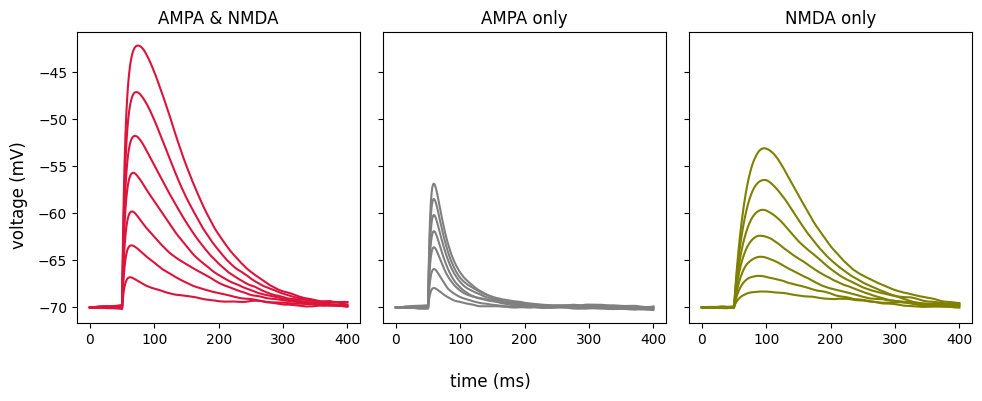

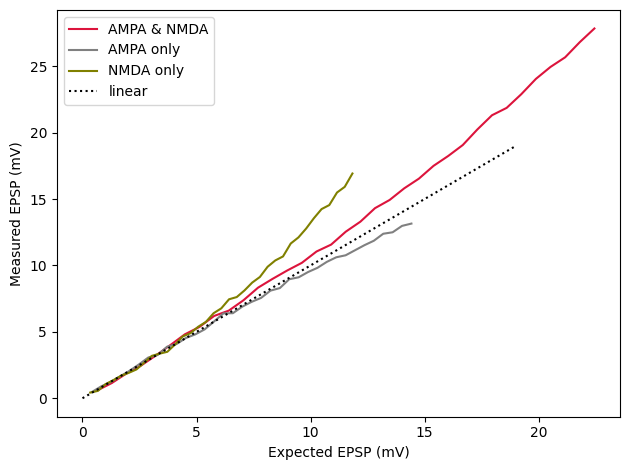

In [10]:
### Define neurons
maxnumsyn = 35
# Adjust synaptic g to adjust synaptic EPSPs 
g_AMPA_distal = 2*nS
g_NMDA_distal = 4*nS
# Adjust noise
sigma_noise_distal = sigma_noise_basal = 1*pA
g = b.NeuronGroup(
    N=maxnumsyn,
    model=multicpt_model,
    refractory=3*ms,
    threshold='V_soma > Vth',
    reset='V_soma = Vr',
    method='euler')
for cpt in CPTS:
    setattr(g, f'V_{cpt}', LVARS[f'EL_{cpt}'])
### Define spike generator input neurons
spiketimes = [50*ms]*maxnumsyn
indices = range(maxnumsyn)
i = b.SpikeGeneratorGroup(maxnumsyn, indices, spiketimes)
### Define the following synaptic scenarios:
# AMPA & NMDA or only AMPA or only NMDA channels activated
syn_effect_AMPA = 's_AMPA_distal += 0.1'
syn_effect_NMDA = 's_NMDA_distal += 0.1'
syn_effects = [syn_effect_AMPA, syn_effect_NMDA]
syn_scenarios = [';'.join(syn_effects), syn_effect_AMPA, syn_effect_NMDA]
### Define network
monvars = ('V_basal', 'V_soma', 'V_apical', 'V_distal')
m = b.StateMonitor(g, monvars, record=True)
n = b.Network(g, i, m)
n.store()
# Monitor variable vectors per synaptic scenario
ss_mn_vectors = dict.fromkeys(monvars, {})
duration = 400*ms
### Simulate every synaptic scenario
for ss in syn_scenarios:
    n.restore()
    syn = b.Synapses(i, g, on_pre=ss)
    syn.connect(condition='j >= i')
    n.add(syn)
    n.run(duration)
    # Monitor variable vectors (e.g. voltages)
    for mn in monvars:
        ss_mn_vectors[mn][ss] = getattr(m, mn)/mV
    # Remove synapse object from network for next restore() to work
    n.remove(syn)
### Plot EPSPs per synaptic scenario
ss_labels = ['AMPA & NMDA', 'AMPA only', 'NMDA only']
ss_colors = ['crimson', 'gray', 'olive']
assert len(ss_labels) == len(ss_colors) == len(syn_scenarios)
zipped_syn_scenarios = list(zip(syn_scenarios, ss_colors, ss_labels))
start, step = 5, 5
stop = maxnumsyn + step
time = m.t/ms
# Monitor variable we are interested in plotting in EPSPs-related plots
plots_monvar = 'V_distal'
nrows, ncols = 1, len(syn_scenarios)  # plus one subplot for 
fig, ax = b.plt.subplots(nrows, ncols, figsize=[10, 4], sharex=True, sharey=True)
for ssi, (ss, ssc, sst) in enumerate(zipped_syn_scenarios):
    axis = ax[ssi]
    axis.set_title(sst)
    for syni in range(start, stop, step):
        axis.plot(time, ss_mn_vectors[plots_monvar][ss][syni-1], c=ssc)
fig.supylabel('voltage (mV)')
fig.supxlabel('time (ms)')
fig.tight_layout()
### Plot I/O function (expected - non-expected EPSPs) per synaptic scenario
# Assumes voltage format V_{cpt}
cpt = plots_monvar.split('_')[1]
absEL = abs(LVARS[f'EL_{cpt}'])/mV
uepsp_idx = 5
fig, ax = b.subplots()
for ss, ssc, sst in zipped_syn_scenarios:
    # When there is noise (realistic scenario), the uEPSP (EPSP of 1 synapse)
    # cannot be accurately estimated. Since for up to 5 synapses the total EPSP
    # is pretty close to the expected EPSP (approximately linear relationship),
    # we can thus infer the uEPSP as such: e.g. (total EPSP from 5 synapses)/5.
    vs = ss_mn_vectors[plots_monvar][ss]
    measured = [max(v)+absEL for v in vs]  # peak (maximum) EPSPs
    uepsp = measured[uepsp_idx-1]/uepsp_idx  # unitary peak EPSP
    expected = b.linspace(1, maxnumsyn, maxnumsyn) * uepsp
    ax.plot(expected, measured, c=ssc, label=sst)
# Plot linear relationship
line = range(20), range(20)
ax.plot(*line, c='black', ls=':', label='linear')
ax.legend()
ax.set_xlabel('Expected EPSP (mV)')
ax.set_ylabel('Measured EPSP (mV)')
fig.tight_layout()

### Example 5

Repeat **exercise 3** using the [`SpatialNeuron`](https://brian2.readthedocs.io/en/latest/user/multicompartmental.html#creating-a-spatially-extended-neuron) compartmental model.

In [ ]:
# morpho = b.Cylinder(length=25um, diameter=25um, n=1)
# morpho.dendrite = b.Cylinder(length=300um, diameter=1um,  n=3)

# eqs = '''
# Im = GL * (EL - v) : amp/meter*2
# I : amp (point current)
# I_ampa = G_AMPA (E_AMPA - v) * s_ampa : amp (point current)
# ds_ampa/dt = -s_ampa / TAU_AMPA : 1
# '''

# spatial_neuron = b.SpatialNeuron(morphology=morpho, model=eqs, Cm=CM, Ri=RI,
#                                  threshold='v > -40mV', reset='v = -50mV',
#                                  refractory=3*ms, threshold_location=0,
#                                  method=INTEGRATION_METHOD)

# S1 = b.Synapses(Input, spatial_neuron[3], on_pre='s_ampa += 1')
# S1.connect(j='i')

# # Initialize voltage
# spatial_neuron.v = EL

# # Set monitors
# M_soma = b.StateMonitor(spatial_neuron, 'v', record=[0])
# M_dend0 = b.StateMonitor(spatial_neuron.dendrite[0], 'v', record=True)
# M_dend1 = b.StateMonitor(spatial_neuron.dendrite[1], 'v', record=True)
# M_dend2 = b.StateMonitor(spatial_neuron.dendrite[2], 'v', record=True)
# Spikes1 = b.SpikeMonitor(spatial_neuron)

In [ ]:
spatialneuron_multicpt_model = '''
Im = gL*(EL-v) : amp/meter**2
I : amp (point current)
ds_NMDA/dt = -s_NMDA/tau_NMDA : 1
ds_ampa/dt = -s_ampa/tau_AMPA : 1
'''
print(spatialneuron_multicpt_model)


Im = gL*(EL-v) : amp/meter**2
I : amp (point current)
ds_NMDA/dt = -s_NMDA/tau_NMDA : 1
ds_ampa/dt = -s_ampa/tau_AMPA : 1



In [ ]:
### Model parameters
gL = 60*uS/cm**2  # specific resistance
Cm = 1*uF/cm**2  # specific leakage conductance
Ri = 150*ohm*cm  # intracellular resistivity (axial resistance)
### Create compartmental model
soma = b.Soma(diameter=30*um)
soma.basal = b.Cylinder(length=10*um, diameter=1*um)  # basal dendrite
soma.apical = b.Cylinder(length=50*um, diameter=2*um)  # apical apical
soma.apical.distal = b.Cylinder(length=10*um, diameter=1*um)  # distal dendrite
assert soma.n == soma.basal.n == soma.apical.n == soma.apical.distal.n == 1
assert soma.total_compartments == soma.total_sections == 4
# soma.topology()
g = b.SpatialNeuron(
    name='spatialneuron',
    morphology=soma,
    Cm=Cm,
    Ri=Ri,
    model=spatialneuron_multicpt_model,
    method='exponential_euler',
)
g.v = EL
monvars = ('v',)
mon = b.StateMonitor(g, monvars, record=True)
n = b.Network(g, mon)
# ...